Nesse notebook treinarei um modelo de arquitetura transformer, tendo como dataset unica e exclusivamente o Livro do Desassossego, de Bernardo Soares, heterônimo do autor português Fernando Pessoa. O objetivo final do simples modelo será criar sentenças parecidas com a do autor partindo de um texto inicial, uma seed, a qual será completada pelo modelo.

#Bibliotecas:

In [ ]:
#Farei o modelo usando como apoio as funções disponibilizadas pelo tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import numpy as np
import os
import string
import random

#Funções

Para construirmos a arquitetura do transformer, usada pelo chatgpt, e que fará a criação do texto nesse notebool, devemos primeiro inicializar suas funções, para assim construir o modelo e treiná-lo.

##Embedding posicional e posicional

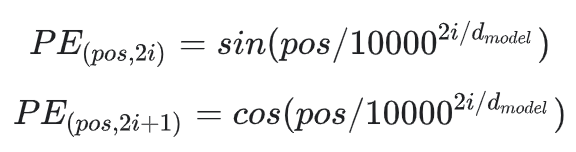

O transformer não apresenta nenhuma camada recorrente, então para manter as informações de posição de tokens na sentença, podendo o modelo aprender com os tokens anteriores da frase, usamos essa codificação sequencial, que é um vetor que guarda os valores posicionais dos tokens, usando a fórmula acima, e depois é incorporado ao vetor calculado pelos módulos de atenção.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):# vocab_size é o tamanho máximo do vocabulário formado
                                                      #maxlen é o tamanho máximo da sequência formada
                                                      #embed_dim é o número de dimensões dos embeddings de cada token
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) #Essa é o embedding das palavras que serão o input
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        posições = tf.range(start=0, limit=maxlen, delta=1)
        posições = self.pos_emb(posições)
        x = self.token_emb(x)
        return x + posições

#Máscara

A mascára de atenção é usada para fazer o modelo ignorar os próximos valores de uma sequência, assim para prever um token na posição n, ele só usará os valores de entrada de anteriores a posição n, o terceiro token só usará o segundo e o primeiro, por exemplo.

In [ ]:
def mascara_atencao(batch_size, n_dest, n_src, dtype):
  #n_dest se refere ao número de tokens que estão sendo considerados como destinos para a operação de atenção
  #basicamente o número de elementos que estão recebendo ateção
  #n_src  se refere ao número de tokens que estão sendo usados como fonte para calcular a atenção
  #basicamente o número de elementos que estão fornecendo informações para calcular a atenção
  #Eles corresponderão normalmente ao tamanho da sequência de entrada
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0)
    return tf.tile(mask, mult)

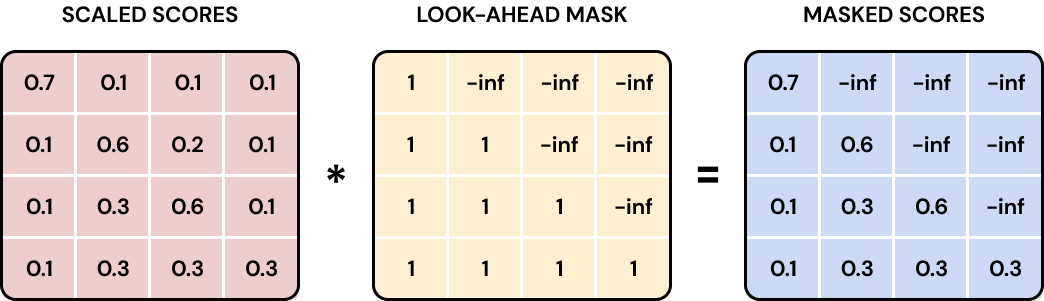

Esse é basicamente o funcionamento dela

#Transformer

Agora sim irei para o código do transformer, mas antes devo explicar os mecanismos que fazem essa arquitetura ser até hoje o estado da arte dos modelos de linguagem.

Primeiro devo falar do seu principal mecanismo de funcionamento, a atenção:

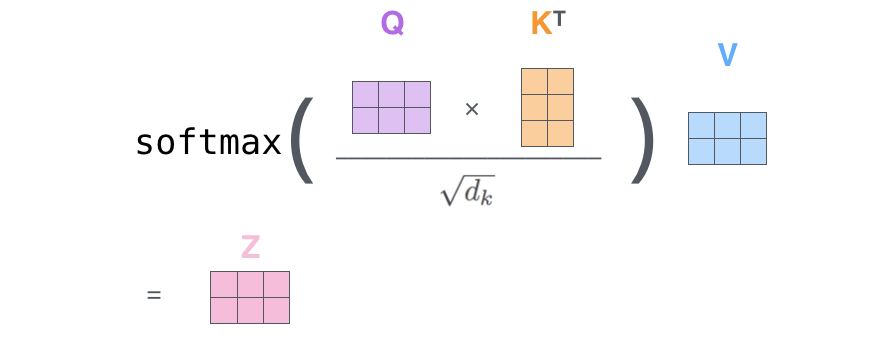

A matriz de atenção, Z na figura acima, utilizada pelo transformer, usa 3 entradas, as quais são utilizadas na fórmula acima e dão o valor final, detalhando cada matriz:

Matriz Q (Query): A matriz Q contém consultas que representam palavras de entrada e é usada para calcular a similaridade entre essas palavras e as palavras na sequência de saída.

Matriz K (Key): A matriz K contém chaves associadas às palavras de entrada e é usada para calcular a similaridade entre as consultas na matriz Q e as chaves na matriz K.

Matriz V (Value): A matriz V contém valores relacionados às palavras de entrada e é usada para calcular uma média ponderada das informações das palavras, onde os pesos de atenção determinados por Q e K controlam a importância de cada valor.

O dk se refere à dimensão das matrizes Q e K, a raiz quadrada de dk é usada para dimensionamento, para que você obtenha uma variação consistente, independentemente do valor de dk.

A partir desse mecanismo podemos construi a Multi-head Attention

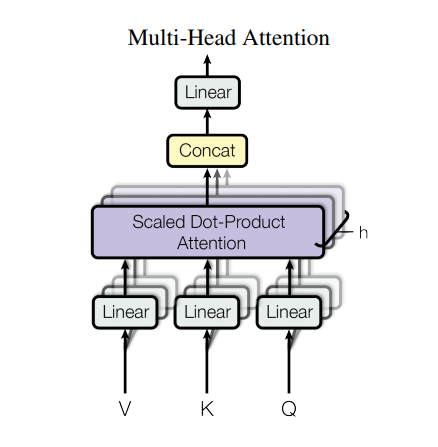

A multi-head attention consiste em algumas partes, primeiro as 3 entradas detalhadas anteriormente, as matrizes V, K e Q, passam por h camadas lineares, sendo h um hiperparâmetro que indica o número "cabeças" por quais ela passará, isso nada mais é que várias camadas de atenção de produto escalar, que no final serão concatenadas, passando por uma última camada linear.


Unindo todos esses mecanismos com redes feedfoward, as redes neurais mais simples, e camadas de normalização temos enfim o transformer

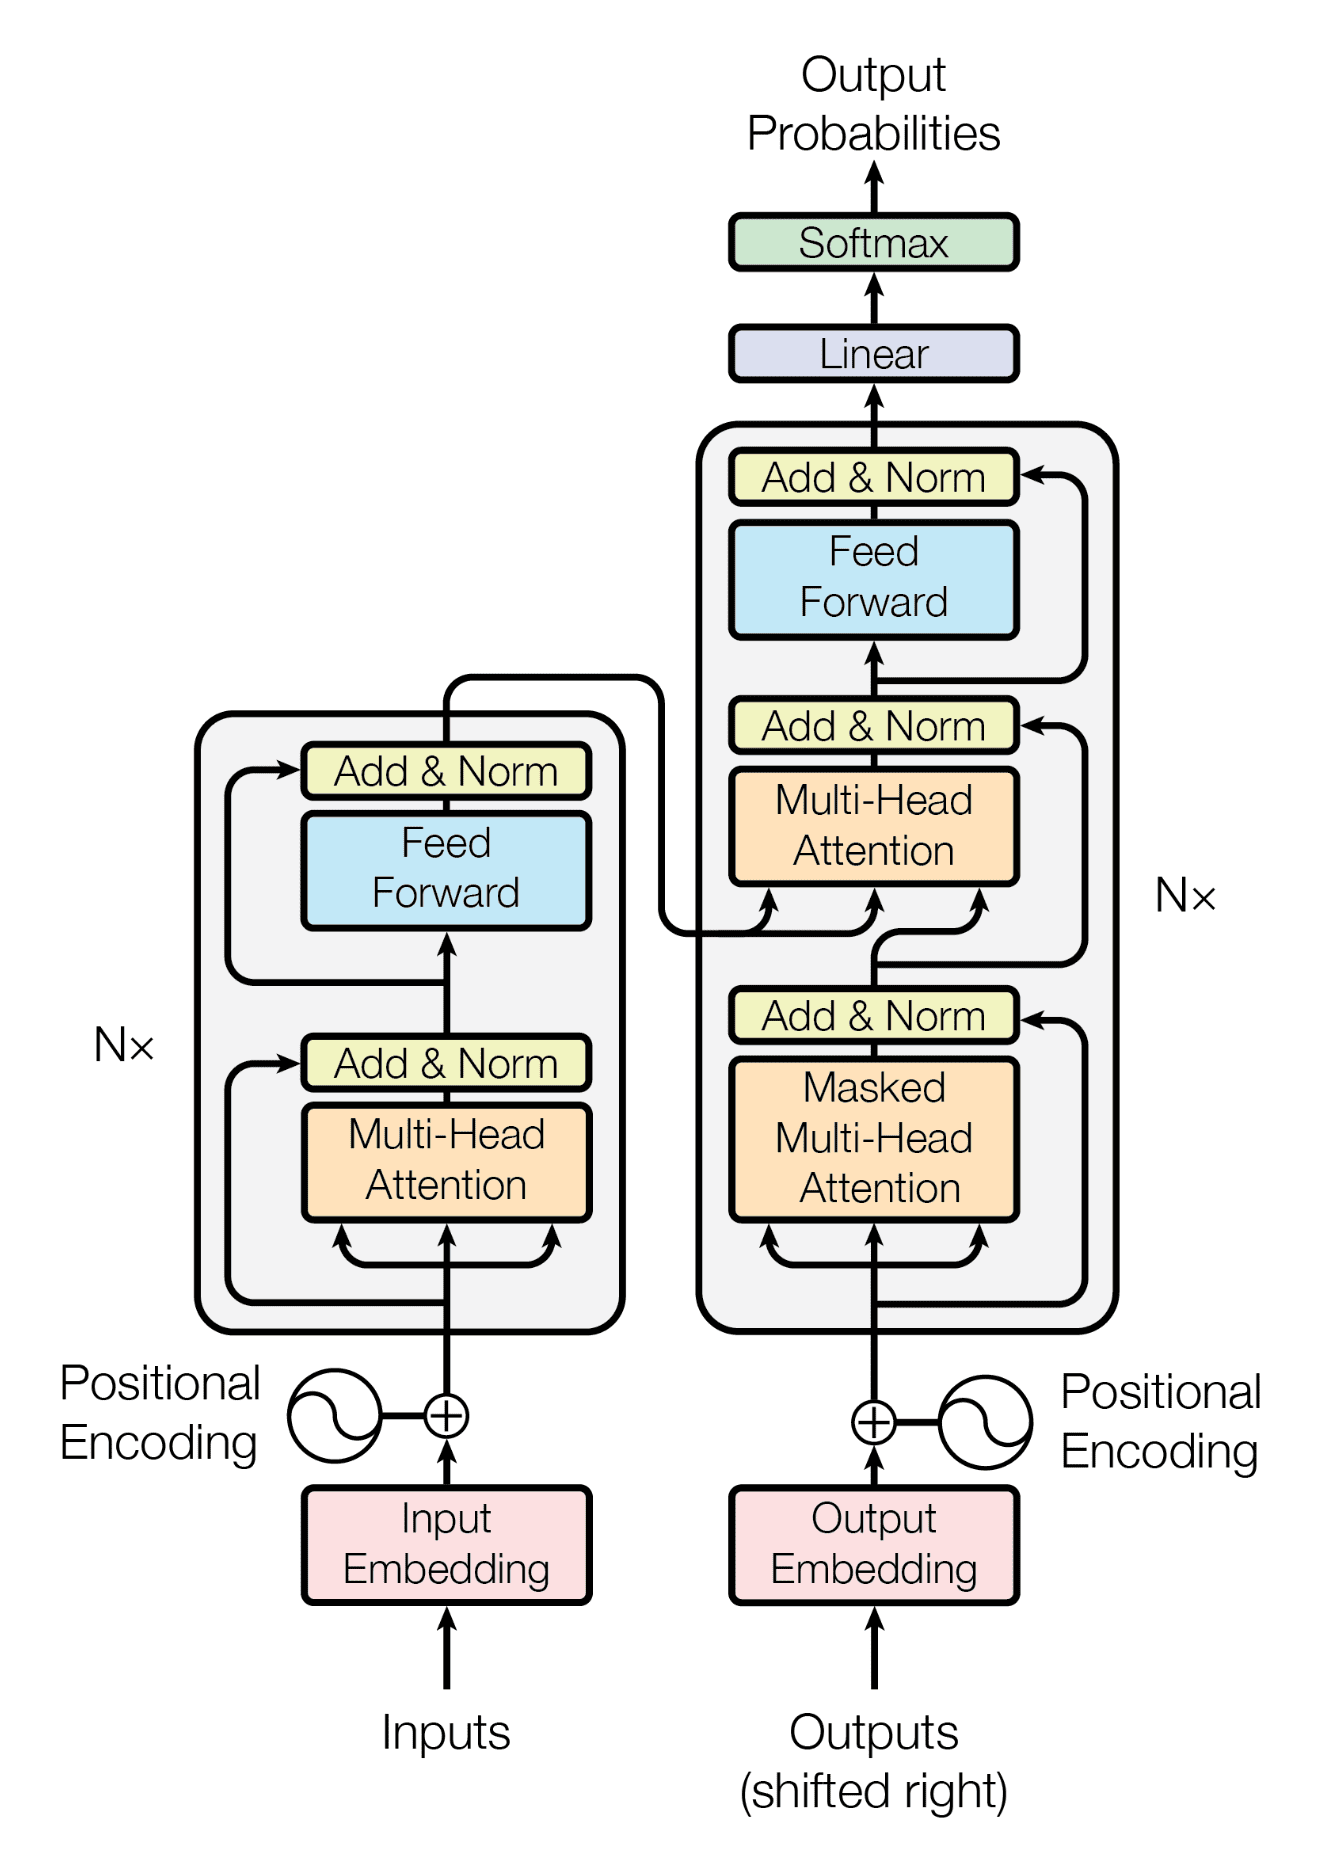

Ele é dividido em dois blocos, o codificador e o decodificador:

O codificador do transformer é o bloco da esquerda, nele cada uma das N camadas consiste em 2 subcamadas: A Multi-head Attention e a rede feed foward

Cada uma dessas subcamadas tem uma conexão residual ao seu redor seguida por uma normalização de camada. As conexões residuais ajudam a evitar o problema do gradiente de fuga em redes profundas.

A saída de cada subcamada é somada à conexão residual, essa soma é então normalizada.

Já no decodificador, o bloco da direita, cada uma das N camadas consiste em 3 subcamadas: A Multi-head Attention mascarada (com máscara de antecipação; Multi-head Attention. As matrizes V e K recebem a saída do encoder como entradas. Já a Q recebe a saída da subcamada de atenção  Multi-head Attention mascarada; e a rede feed foward

Cada uma dessas subcamadas também tem uma conexão residual ao seu redor seguida por uma normalização de camada.

Como o segundo bloco de atenção recebe Q do primeiro bloco do decodificador, enquanto recebe K e V do codificador, os pesos representam a importância dada à entrada do decodificador com base na saída do codificador, dessa forma o decodificador prevê o próximo token observando a saída do codficador e então prevendo sua própria saído.



O transformer que usarei, como tem o objetivo de imitar a arquitetura usada pelo modelo do GPT, apresentará apenas o decoder, logo apenas utilizará o bloco da direita da imagem.

In [ ]:
#Usarei a função do keras de Multi-head Attention, assim como as outras layers denses e feedfoward
#falar como esse código do transformer só tem o decoder, assim como o gpt
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
      #Num_heads é o número de heads de atenção
      #ff_dim é o número de neuronios da rede feedfoward
      #rate é a porcentagem do dropout no modelo
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mascara = mascara_atencao(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=mascara)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output) #Tanto o output 1 quanto o 2 tem a soma dos residuais, sendo os inputs e o output 1 respectivamente

#Dataset e tokenização

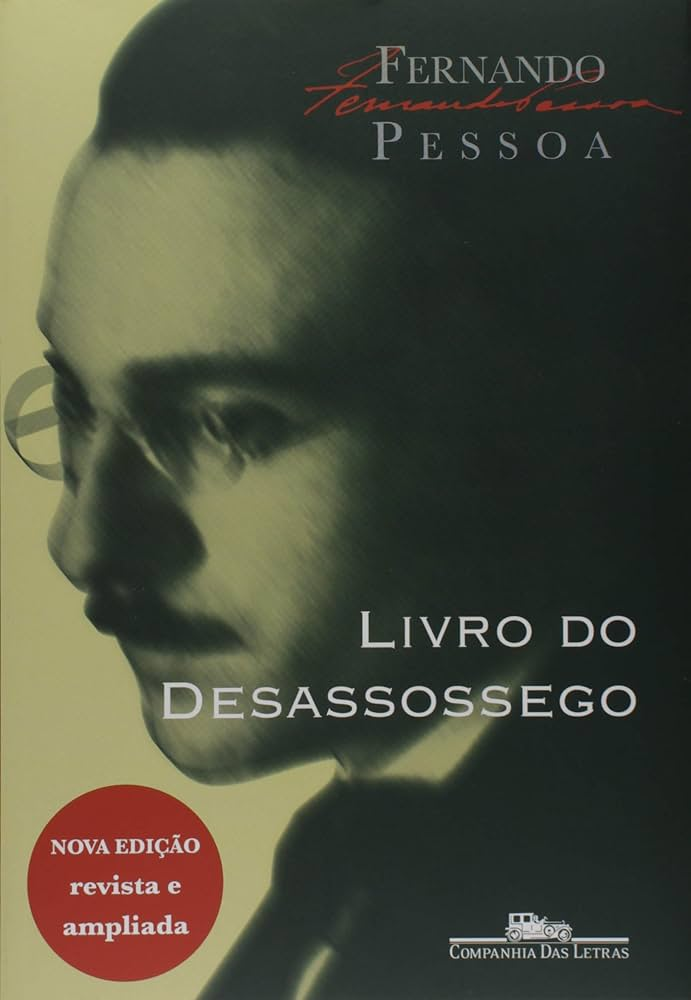

Como dataset usarei apenas o Livro do Desassossego, única obra conhecida de Fernando Pessoa que pode ser considerado como um romance. Escolhi-a apenas por ser minha obra favorita, tendo o interesse de testá-la em um gerador de texto, seu estilo me faz imaginar resultados interessantes.

Para criar o dataset nada mais fiz do que usar o texto integral da obra a partir de um arquivo em formato txt, nele apenas retirei as partes iniciais do livro, capa, índice, prefácio, informações básicas sobre o autor e sobre a obra, basicamente tudo escrito posteriormente ao autor.

In [ ]:
#Setando os parâmetros
vocab_size = 20000 #Esse parâmetro diz respeito ao número de tokens gerados na tokenização e que serão considerados pelo modelo.
#Na última camada, na hora da previsão da palavra a ser usada, o tamanho do vetor de probabilidades será o número desse parâmetro
#Usei um número consideravelmente grande, pois imagino que pelo tipo de texto, o número de palavras únicas pode ser grande.

maxlen = 120  #Esse parâmetro define o tamanho máximo de cada sequência usada como input.
#Não usarei um número muito grande, pois os tokens são de palavras e não quero gerar nada além de algumas pequenas sentenças.

In [ ]:
batch_size = 16 #Sendo apenas um livro não terei muitas textos, logo usarei um batch size pequeno
text_ds = tf.data.TextLineDataset('/content/Livro-do-Desassossego-.txt')
text_ds = text_ds.shuffle(buffer_size=64)#buffer size diz respeito ao número de sequencias armazenadas na memória temporária
                                         #Desempanhando um importante trabalho no embaralhamento dos dados, evitando o encontro de padrões gerados pelas setenças em ordem.
text_ds = text_ds.batch(batch_size)

In [ ]:
#A função revome alguns símbolos e tags
#além disso deixa o texto todo minúsculo e separa as pontuações por espaços, para tokens desnecessários não serem gerados
def padronizacao(input_string):
    lower = tf.strings.lower(input_string)
    tags_html = tf.strings.regex_replace(lower, "<br />", " ")
    return tf.strings.regex_replace(tags_html, f"([{string.punctuation}])", r" \1")

Para usar o texto no modelo é necessário fazer a tokenização nas sentenças do dataset, as transformando em números, vetorizá-las, algo que o modelo consegue ler.
Há várias formas de tokenizar, podemos fazer isso caractér por caractér, sendo o mais simples por gerar apenas os tokens necessários para ter todos os caracteres da língua portuguesa. Podemos também tokenizar por palavra, algo que gera muito mais tokens, pois cada palavra única do dataset seria um token. Há por último uma abordagem intermediária, as chamadas subwords, um tipo de tokenização muito usada, que utiliza partes da palavras como tokens. Utilizarei a tokenização por palavras, o dataset é pequeno e o treinamento do modelo será simples, logo utilizar esse tipo de tokenização não complicará muito o modelo.

In [ ]:
#Criando uma layer de vetorização e a adapatando ao dataset
vectorize_layer = TextVectorization(
    standardize=padronizacao,
    max_tokens=vocab_size - 1,
    output_mode="int", #Os outputs, sendo vetores, serão inteiros.
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab2 = vectorize_layer.get_vocabulary()

In [ ]:
#A função tokeniza o texto, criando pares de sequências de input e label,
#Muda a sequência de palavras por uma posição para o target da posição i ser i+1, logo o modelo usará apenas as palavras até a posição i para a previsão
def modelo_inputs_labels(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y
text_ds = text_ds.map(modelo_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

#Hiperparâmetros e modelo

Agora vou criar a função com o modelo, além disso setar os parâmetros usados por ele.

Por ser um modelo simples, com poucos parâmetros quando comparado a outros transformers, optei por usar apenas uma camada de decodificador, o n da figura do transformer

In [ ]:
#Tanto vocab_size e maxlen serão usados como hiperparâmetros do modelo, mas já estão definidos acima
embed_dim = 256  # é o número de dimensões do embedding de cada token
num_heads = 2  # Número de attention heads, o h na imagem sobre a multi-head attention
feed_forward_dim = 256  #o tamanho da hidden layer da rede feedfoward do transformer

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)#embedding dos tokens e codificação posicional
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)#Camada única apenas de decoder
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)#Rede linear final que gera os resultados probabilísticos do próximo token.
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #Essa é caracterizada como a melhor função de perda para geração de texto
    model.compile( "adam", loss=[loss_fn, None],)
    return model

#Treinamento:

In [ ]:
#Vou criar agora uma classe de callback para durante o treinamento do modelo as frases serem geradas e printadas a cada epoch de treino
#Para isso deverei coloca uma seed de texto para ele continuar, como se fosse o meu prompt do chat gpt, só que ele apenas continuará o texto.
#Então o modelo fará a previsão do próximo token, que pode ser uma palavra, pontuação, fim ou padding
#Adciona o token previsto a frase, criando um novo input, termina então printando o a frase com a seed e os tokens previstos
class TextGenerator(keras.callbacks.Callback):

    def __init__(self, max_tokens, start_tokens, index_to_word, top_k=10, print_a_cada=1):
        #max_tokens se refere ao máximo de tokens gerados após o prompt
        #start_tokens é uma lista de inteiros com as palavras do prompt tokenizadas
        #top_k é um parâmetro que define os k tokens utilizados para a previsão, esse top se baseia nos 10 com mais probabilidade.
        #print_a_cada diz a cada quantas epochs deve ser printada a frase, está padronizado para 1, printando toda epoch
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_a_cada = print_a_cada
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, num):
        return self.index_to_word[num]

    def fim_epoch(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_a_cada != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Para Tokenizar o texto usado como seed
word_to_index = {}
for index, word in enumerate(vocab2):
    word_to_index[word] = index

seed = "seria mais feliz se" #Essa seed já é de um segundo treinamento feito em outro momento dentro do colab
start_tokens = [word_to_index.get(_, 1) for _ in seed.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab2)

In [ ]:
model = create_model()
model.summary() #Basicamente os parâmetro que farão o modelo ficar grande são: o tamanho do vocabulário, dimensões dos embeddings e da rede feedfoward

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 token_and_position_embeddi  (None, 120, 256)          5150720   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 120, 256)          658688    
 rmerBlock)                                                      
                                                                 
 dense_2 (Dense)             (None, 120, 20000)        5140000   
                                                                 
Total params: 10949408 (41.77 MB)
Trainable params: 10949408 (41.77 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
model.fit(text_ds, verbose=2, epochs=25, callbacks=[text_gen_callback])

Epoch 1/25
1/1 [==============================] - 0s 21ms/step
generated text:
a vida é a uma figura e , não sei se não se não sei e a um                          

1694/1694 - 63s - loss: 0.5134 - dense_2_loss: 0.5134 - 63s/epoch - 37ms/step
Epoch 2/25
1/1 [==============================] - 0s 35ms/step
generated text:
a vida é que eu o ser o próprio . . e assim os meus sonhos . .                          

1694/1694 - 45s - loss: 0.3839 - dense_2_loss: 0.3839 - 45s/epoch - 27ms/step
Epoch 3/25
1/1 [==============================] - 0s 25ms/step
generated text:
a vida é a crueldade da minha atenção .                                   

1694/1694 - 45s - loss: 0.3278 - dense_2_loss: 0.3278 - 45s/epoch - 27ms/step
Epoch 4/25
1/1 [==============================] - 0s 33ms/step
generated text:
a vida é a tia anica (veja a carta dela )                                 

1694/1694 - 46s - loss: 0.2804 - dense_2_loss: 0.2804 - 46s/epoch - 27ms/step
Epoch 5/25
1/1 [============================

In [ ]:
#Ainda assim o treinamento demorou por volta de 12 minutos usando a gpu do colab

In [ ]:
model.save('modelo_desassossego2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Treinei mais uma vez apenas para ver como se sairia com outra frase, mas nos textos futuros usarei o primeiro e salvo modelo
model.fit(text_ds, verbose=2, epochs=25, callbacks=[text_gen_callback])

Epoch 1/25
1/1 [==============================] - 0s 20ms/step
generated text:
seria mais feliz se me não sei para um que é uma coisa que eu ,                             

1694/1694 - 56s - loss: 0.5141 - dense_5_loss: 0.5141 - 56s/epoch - 33ms/step
Epoch 2/25
1/1 [==============================] - 0s 21ms/step
generated text:
seria mais feliz se o não pode ser , porque o meu amor . .                              

1694/1694 - 44s - loss: 0.3827 - dense_5_loss: 0.3827 - 44s/epoch - 26ms/step
Epoch 3/25
1/1 [==============================] - 0s 18ms/step
generated text:
seria mais feliz se a vida .                                      

1694/1694 - 43s - loss: 0.3260 - dense_5_loss: 0.3260 - 43s/epoch - 26ms/step
Epoch 4/25
1/1 [==============================] - 0s 22ms/step
generated text:
seria mais feliz se deu a dor .                                     

1694/1694 - 44s - loss: 0.2783 - dense_5_loss: 0.2783 - 44s/epoch - 26ms/step
Epoch 5/25
1/1 [==============================] - 

#Função de geração de textos

In [ ]:
#Por o modelo ter classes não criadas pelo keras devo criar esse dicionário para não ocorrer problema na hora de dar load nele
custom_objects = {
    'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
    'TransformerBlock': TransformerBlock
}

In [ ]:
modelo=tf.keras.models.load_model('modelo_desassossego2_final.h5', custom_objects=custom_objects)

In [ ]:
#Criando uma função que recebe o modelo o número, a seed de texto, máximo de tokens gerados e maxlen, que deve ser igual a do modelo
def gerador_texto(modelo, seed, max_token, maxlen=maxlen):
  start_tokens = [word_to_index.get(_, 1) for _ in seed.split()]
  num_tokens_generated = 0
  tokens_generated = []
  text_gen = TextGenerator(num_tokens_generated, start_tokens, vocab2)
  while num_tokens_generated <= max_tokens:
    pad_len = maxlen - len(start_tokens)
    sample_index = len(start_tokens) - 1
    if pad_len < 0:
      x = start_tokens[:maxlen]
      sample_index = maxlen - 1
    elif pad_len > 0:
      x = start_tokens + [0] * pad_len
    else:
      x = start_tokens
    x = np.array([x])
    y, _ = modelo.predict(x, verbose=0)
    sample_token = text_gen.sample_from(y[0][sample_index])
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
    txt = " ".join([text_gen.detokenize(_) for _ in start_tokens + tokens_generated])
  print(f"texto gerado:\n{txt}\n")

#Testes:

In [ ]:
seed='era uma vez'
max_tokens=80

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
era uma vez de cor de mais que um dos sonhos , e mesmo                                                                       de cor de mais que um dos sonhos , e mesmo                                                                      



In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
era uma vez de um técnica do sonho há as as há das diversas realidades . e                                                                    de um técnica do sonho há as as há das diversas realidades . e                                                                   



In [ ]:
seed='já imaginei'
max_tokens=80

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
já imaginei passaste , e já para ontem -lhe sentir                                                                          passaste , e já para ontem -lhe sentir                                                                         



In [ ]:
seed='estou muito bem , meus sonhos são'

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
estou muito bem , meus sonhos são — mas vivi sempre me houvessem .                                                                           — mas vivi sempre me houvessem .                                                                          



In [ ]:
seed='meus sentimentos estão confusos , tive que caminhar até'

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
meus sentimentos estão [UNK] , tive que caminhar até a minha alma . É que não sei                                                                          a minha alma . É que não sei                                                                         



In [ ]:
seed='o seu sorriso me faz'
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
o seu sorriso me faz , como lembrar a um sonho de saúde e o                                                                        , como lembrar a um sonho de saúde e o                                                                       



In [ ]:
seed='minha alma'
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
minha alma , para cada coisa me é a sua desolação .                                                                        , para cada coisa me é a sua desolação .                                                                       



In [ ]:
seed='o por do sol'
max_tokens=30

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
o por do sol morto de um sonho , tendo a minha alma e aquele                     morto de um sonho , tendo a minha alma e aquele                    



In [ ]:
seed='sonhar é'
max_tokens=80

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
sonhar é , ou para a renúncia , a emoção é um nexo , feliz .                                                                    , ou para a renúncia , a emoção é um nexo , feliz .                                                                   



In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
sonhar é através do acaso de existir .                                                                            através do acaso de existir .                                                                           



In [ ]:
seed='minha alma está'
max_tokens=100

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
minha alma está daquele paraíso . . só quem comigo se não pode ergue , de                                                                                         daquele paraíso . . só quem comigo se não pode ergue , de                                                                                        



In [ ]:
seed='a vida é'

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
a vida é um brinquedo de criança na areia . . .                                                                                             um brinquedo de criança na areia . . .                                                                                            



In [ ]:
seed='a vida é'

In [ ]:
gerador_texto(modelo, seed, max_tokens, maxlen=80)

texto gerado:
a vida é para os outros , porque nada se não têm a realidade ,                                                                                          para os outros , porque nada se não têm a realidade ,                                                                                         



#Fontes



https://www.tensorflow.org/text/tutorials/transformer?hl=pt-br#export

https://keras.io/examples/generative/text_generation_gpt/#random-search

https://keras.io/examples/generative/text_generation_with_miniature_gpt/

https://doi.org/10.48550/arXiv.1706.03762 (Attention is all you need)

https://www.youtube.com/playlist?list=PLTl9hO2Oobd97qfWC40gOSU8C0iu0m2l4